In [53]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

sys.path.append("../")
from deepnets import nnModels as models
from deepnets import nnExperiments as nnexp
from deepnets import nnUtilities as nnutils

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

dataPath = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [128]:
useNet='MLP4'
iterations=50
learningRate=5e-2
verbose=True
doInitWeights=False
ojaAlpha=0
pDropout=0

# First, select device to run networks on
if DEVICE is None:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CPU = "cpu"
print(f"Initiating experiment using {DEVICE}")

# Prepare Network and Preprocessing
batchSize = 1000
weightvars = None # initialize variance of weights with default parameters
if useNet=='CNN2P2':
    convActivation = F.relu
    linearActivation = F.relu
    net = models.CNN2P2(convActivation=convActivation,linearActivation=linearActivation)

    preprocess = transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
    ])
elif useNet=='MLP3':
    actFunc = F.relu
    net = models.MLP3(actFunc=actFunc)

    preprocess = transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
        transforms.Lambda(torch.flatten), # convert to vectors
    ])
elif useNet=='MLP4':
    actFunc = F.relu
    net = models.MLP4(actFunc=actFunc,pDropout=pDropout)

    preprocess = transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
        transforms.Lambda(torch.flatten), # convert to vectors
    ])
else:
    raise ValueError('useNet not recognized')

net.to(DEVICE)

# Prepare Dataloaders
trainloader, testloader, numClasses = nnutils.downloadMNIST(batchSize=batchSize, preprocess=preprocess)

# Prepare Training Functions 
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...
# optimizer = torch.optim.SGD(net.parameters(), lr=learningRate)
optimizer = torch.optim.Adadelta(net.parameters())

# Preallocate summary variables  
numTrainingSteps = len(trainloader)*iterations
trackLoss = torch.zeros(numTrainingSteps)
trackAccuracy = torch.zeros(numTrainingSteps)
alignFull = []
deltaWeights = []

initWeights = net.getNetworkWeights()

# Train Network & Measure Integration
t = time.time()
for epoch in range(0, iterations): 
    # Set current loss value
    currentLoss = 0.0
    numBatches = 0
    currentCorrect = 0
    currentAttempted = 0

    for idx,batch in enumerate(trainloader):
        cidx = epoch*len(trainloader) + idx

        images, label = batch
        images = images.to(DEVICE)
        label = label.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(images)

        # Perform backward pass & optimization
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        if ojaAlpha>0:
            net.doOjaUpdate(images, learningRate*ojaAlpha)

        # Measure Integration
        alignFull.append(net.measureAlignment(images))

        # Measure Change in Weights
        deltaWeights.append(net.compareNetworkWeights(initWeights))

        # Track Loss and Accuracy
        trackLoss[cidx] = loss.item()
        trackAccuracy[cidx] = 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]

    # Print statistics for each epoch
    if verbose: print('Loss in epoch %3d: %.3f, Accuracy: %.2f%%.' % (epoch, loss.item(), 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]))

# Measure performance on test set
totalLoss = 0
numCorrect = 0
numAttempted = 0
for batch in testloader:
    images, label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    outputs = net(images)
    totalLoss += loss_function(outputs,label).item()
    output1 = torch.argmax(outputs,axis=1)
    numCorrect += sum(output1==label)
    numAttempted += images.shape[0]

print(f"Average loss over test set: %.2f." % (totalLoss / len(testloader)))
print(f"Accuracy over test set: %.2f%%." % (100*numCorrect/numAttempted))
print('Training process has finished in %.3f seconds.' % (time.time()-t))

results = {
    'net':net,
    'initWeights':initWeights,
    'alignFull':alignFull,
    'deltaWeights':deltaWeights,
    'trackLoss':trackLoss,
    'trackAccuracy':trackAccuracy,
    'trainloader':trainloader,
    'testloader':testloader,
    'learningRate':learningRate,
}

Initiating experiment using cuda
Loss in epoch   0: 0.339, Accuracy: 90.20%.
Loss in epoch   1: 0.220, Accuracy: 93.60%.
Loss in epoch   2: 0.150, Accuracy: 95.50%.
Loss in epoch   3: 0.097, Accuracy: 97.20%.
Loss in epoch   4: 0.092, Accuracy: 97.40%.
Loss in epoch   5: 0.152, Accuracy: 95.40%.
Loss in epoch   6: 0.069, Accuracy: 98.00%.
Loss in epoch   7: 0.047, Accuracy: 98.90%.
Loss in epoch   8: 0.049, Accuracy: 98.50%.
Loss in epoch   9: 0.034, Accuracy: 99.10%.
Loss in epoch  10: 0.046, Accuracy: 98.60%.
Loss in epoch  11: 0.042, Accuracy: 98.40%.
Loss in epoch  12: 0.025, Accuracy: 99.20%.
Loss in epoch  13: 0.018, Accuracy: 99.60%.
Loss in epoch  14: 0.025, Accuracy: 99.30%.
Loss in epoch  15: 0.029, Accuracy: 98.80%.
Loss in epoch  16: 0.331, Accuracy: 91.60%.
Loss in epoch  17: 0.012, Accuracy: 99.60%.
Loss in epoch  18: 0.009, Accuracy: 99.70%.
Loss in epoch  19: 0.005, Accuracy: 100.00%.
Loss in epoch  20: 0.003, Accuracy: 100.00%.
Loss in epoch  21: 0.015, Accuracy: 99.60

In [135]:
# Code below will become single function to analyze eigenfeatures of each layer

In [130]:
# Measure Activations (without dropout) for all images
storeDropout = net.getDropout()
net.setDropout(0) # no dropout for measuring eigenfeatures
allimages = []
activations = []
for images, label in tqdm(trainloader):    
    allimages.append(images)
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    activations.append(net.getActivations(images))
net.setDropout(storeDropout)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.48it/s]


In [131]:
# Consolidate variable structure
NL = net.numLayers
allinputs = []
allinputs.append(torch.cat(allimages,dim=0).detach().cpu())
for layer in range(NL-1):
    allinputs.append(torch.cat([cact[layer] for cact in activations],dim=0).detach().cpu())
    
for ai in allinputs: print(ai.shape)

torch.Size([60000, 784])
torch.Size([60000, 100])
torch.Size([60000, 100])
torch.Size([60000, 50])


In [132]:
# Measure eigenfeatures for each layer
eigenvalues = []
eigenvectors = []
for ai in allinputs:
    w,v = sp.linalg.eigh(torch.cov(ai.T))
    widx = np.argsort(w)[::-1]
    w = w[widx]
    v = v[:,widx]
    eigenvalues.append(w)
    eigenvectors.append(v)
for evl,evc in zip(eigenvalues,eigenvectors):
    print(f"EVal Shape: {evl.shape}, EVec Shape: {evc.shape}")

EVal Shape: (784,), EVec Shape: (784, 784)
EVal Shape: (100,), EVec Shape: (100, 100)
EVal Shape: (100,), EVec Shape: (100, 100)
EVal Shape: (50,), EVec Shape: (50, 50)


In [133]:
# Measure dot product of weights for each layer
beta = []
netweights = net.getNetworkWeights()
for evc,nw in zip(eigenvectors,netweights):
    nw = nw / torch.norm(nw,dim=1,keepdim=True)
    beta.append(torch.abs(nw.cpu() @ evc))
for b in beta: print(b.shape)

torch.Size([100, 784])
torch.Size([100, 100])
torch.Size([50, 100])
torch.Size([10, 50])


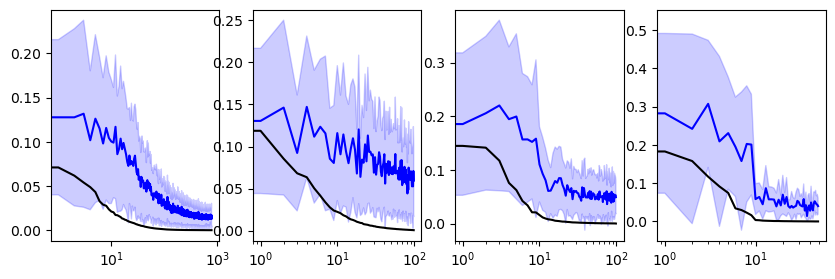

In [134]:
fig,ax = plt.subplots(1,NL,figsize=(10,3))

for layer in range(NL):
    cNEV = len(eigenvalues[layer])
    mnbeta = torch.mean(beta[layer],dim=0)
    sebeta = torch.std(beta[layer],dim=0)
    ax[layer].fill_between(range(cNEV), mnbeta+sebeta, mnbeta-sebeta, color='b', alpha=0.2)
    ax[layer].plot(range(cNEV), mnbeta, c='b', label='AverageProjection')
    ax[layer].plot(range(cNEV), eigenvalues[layer]/np.sum(eigenvalues[layer]), c='k', label='Eigenvalues')
    ax[layer].set_xscale('log')
    # ax[layer].set_yscale('log')